In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
import os

In [3]:
WINDOW_SIZE = 5
WINDOW_SIZE_CONTEXT = 6
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'
casp_protein_id = 'T1038'   # 6ya2
da = DihedralAdherence(casp_protein_id, WINDOW_SIZE, WINDOW_SIZE_CONTEXT, PDBMINE_URL, PROJECT_DIR)
# da.check_alignment(pred_id='T1038TS024_5')
# da.compute_structures()
# da.query_pdbmine()
# da.compute_mds()
da.load_results_md()

Results already exist
PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 


Model R-squared: 0.737118, Adj R-squared: 0.584735, p-value: 1.3550539063370565e-32


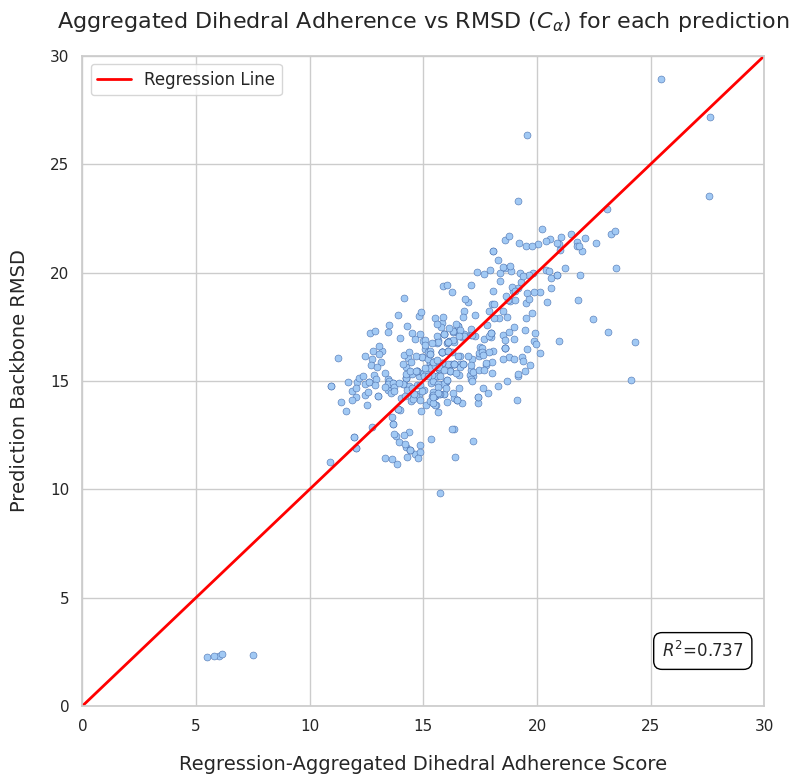

In [55]:
# da.plot_res_vs_md(fn='test.png')
da.plot_md_vs_rmsd(fn='test.png', axlims=((0, 30), (0, 30)))

In [7]:
from lib import fit_model_on_multiple
WINDOW_SIZE = 5
WINDOW_SIZE_CONTEXT = 6
PDBMINE_URL = os.getenv("PDBMINE_URL")

fit_model_on_multiple(['T1030', 'T1038'], WINDOW_SIZE, WINDOW_SIZE_CONTEXT, PDBMINE_URL,)

Results already exist
PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
       protein_id        md     md_std     md_na         Model  RMS_CA
0    T1030TS005_1  8.518580  22.022165  0.131086  T1030TS005_1   9.454
1    T1030TS005_2  8.506571  21.251410  0.127341  T1030TS005_2   8.655
2    T1030TS005_3  8.625927  20.827122  0.146067  T1030TS005_3  16.776
3    T1030TS005_4  9.519318  25.445550  0.146067  T1030TS005_4   8.785
4    T1030TS005_5  8.823896  21.494187  0.097378  T1030TS005_5   8.093
..            ...       ...        ...       ...           ...     ...
457  T1030TS498_1  8.978023  23.685231  0.097378  T1030TS498_1  17.927
458  T1030TS498_2  8.716048  21.157280  0.097378  T1030TS498_2  30.066
459  T1030TS498_3  8.395594  21.781713  0.097378  T1030TS498_3   6.003
460  T1030TS498_4  8.381150  21.570930  0.097378  T1030TS498_4   5.205
461  T1030TS498_5  8.475615  22.242880  0.097378  T1030TS498_5   6.625

[462 rows x 6 columns]
Results already exist
PDB: 6ya2
Structure exists: 'pdb/

/home/musa/dev/protein-dihedral-visualization/.venv/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9107.
  warnings.warn(
/home/musa/dev/protein-dihedral-visualization/.venv/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9135.
  warnings.warn(
/home/musa/dev/protein-dihedral-visualization/.venv/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9163.
  warnings.warn(
/home/musa/dev/protein-dihedral-visualization/.venv/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9219.
  warnings.warn(
/home/musa/dev/protein-dihedral-visualization/.venv/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9261.
  warni

       protein_id         md     md_std     md_na         Model  RMS_CA
0    T1038TS005_1  11.272693  20.522009  0.165803  T1038TS005_1  14.113
1    T1038TS005_4   9.459801  17.791287  0.165803  T1038TS005_4  15.214
2    T1038TS009_1  10.393437  19.108588  0.113990  T1038TS009_1  16.054
3    T1038TS009_2   9.616842  17.121097  0.113990  T1038TS009_2  15.805
4    T1038TS009_3   9.944591  17.599631  0.113990  T1038TS009_3  16.526
..            ...        ...        ...       ...           ...     ...
462  T1038TS498_1   9.923323  17.667933  0.113990  T1038TS498_1  17.198
463  T1038TS498_2  11.066082  21.072531  0.113990  T1038TS498_2  17.165
464  T1038TS498_3  10.305737  18.455067  0.113990  T1038TS498_3  15.773
465  T1038TS498_4   9.588528  18.248973  0.113990  T1038TS498_4  16.777
466  T1038TS498_5   9.371467  19.619443  0.212435  T1038TS498_5  13.706

[467 rows x 6 columns]
